## IMPORT DE BIBLIOTECAS

In [84]:
# import Pacotes
import pandas as pd
import numpy
from pandas import read_csv
import math
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
# Pacotes com Machine Learning
# Usa TensorFlow como backend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.metrics import RootMeanSquaredError

### IMPORT DE DATASET

In [91]:
df_fb = pd.read_csv("./data/FB Historical Data.csv") #Importando os dados historicos
df_fb["Date"] = pd.to_datetime(df_fb["Date"], format="%b %d, %Y") #Convertendo coluna data de STRING para DATETIME

### PREPARAÇÃO DE DADOS PARA O MODELO

In [93]:
df_ = df_fb[["Date","Price"]].sort_values(by="Date").set_index("Date")#Separa os dados a variavel TARGET (Price) e seta a data como index

## FUNÇÃO QUE CRIA DATASET COM JANELA DE DADOS PARA O MODELO

In [96]:
# Cria o DataSet para a Celula LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

### CRIÇÃO DE FUNÇÃO Q RODA O MODELO LSTM E RETORNA OS VALORES OBTIDOS DE RMSE DE TREINO E TESTE

In [99]:
#df = Dataset completo
#Y  = Variavel target 
#look_back = Quantidades de valor da janela de temporal
#Epocas = Numeros de epocas de treino
#train_fraction = Valor de dados de treino e
def do_lstm_model(df, 
                  Y, 
                  look_back = 2, 
                  Epocas = 2,
                  train_fraction = 0.90):

    # Semente do aleatório fixada
    numpy.random.seed(7)

    # Seta os dados
    dataset = df[Y].values
    dataset = dataset.astype('float32')
    # Normaliza para facilitar nos calculos,  entre 0 e 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
    # Separação entre Treino e Teste
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    Treino, Teste = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    # Reshape para X=t e Y=t+1
    look_back = look_back
    TreinoX, TreinoY = create_dataset(Treino, look_back)
    testX, testY = create_dataset(Teste, look_back)

    TreinoX = numpy.reshape(TreinoX, (TreinoX.shape[0], 1, TreinoX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # Chama LSTM e treina a Rede
    batch_size = 1
    model = Sequential()
  
    model.add(LSTM(4, input_shape=(1, look_back)))
  
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(TreinoX, 
              TreinoY, 
              epochs = Epocas, 
              batch_size = 1, 
              verbose = 2)
    
    
    # Predizer os dados
    trainPredict = model.predict(TreinoX)
    testPredict = model.predict(testX)

    # Volta escapa original para Plotar
    trainPredict = scaler.inverse_transform(trainPredict)
    TreinoY = scaler.inverse_transform([TreinoY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
  
    # Calculo da Raiz do Erro Médio Quadrado (RMSE) e apresenta o resultado
    trainScore = math.sqrt(mean_squared_error(TreinoY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    trainScore_str = '%.2f' % (trainScore)
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    testScore_str = '%.2f' % (testScore)
    # Criando vetores de train e teste preditos para plotar
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    return trainScore, testScore

### TESTE DA MODELO

In [100]:
# Lembre-se LoopBack pequeno prevê bem a curto prazo, mas mal a longo prazo
# Por isso o modelo roda em Iterações contínuas de acordo com o tempo e a todo momento
trainScore, testScore = do_lstm_model(df = df_, 
              Y = 'Price', 
              look_back = 5,
              Epocas = 3)
trainScore, testScore

Epoch 1/3
606/606 - 1s - loss: 0.0298 - 925ms/epoch - 2ms/step
Epoch 2/3
606/606 - 0s - loss: 0.0014 - 323ms/epoch - 533us/step
Epoch 3/3
606/606 - 0s - loss: 8.0175e-04 - 313ms/epoch - 517us/step
606 - 606
Train Score: 6.89 RMSE
63 - 63
Test Score: 7.38 RMSE


(6.894261173721916, 7.375012721033151)

### LOOP PARA DESCOBRIR MELHOR VALOR DE EPOCAS E LOOPBACKS PARA O MODELO

In [63]:
df_results = pd.DataFrame()
for lb in range(1,30):
    for ep in range(1,30):
        trainScore, testScore = do_lstm_model(df = df_, 
              Y = 'Price', 
              look_back = lb,
              Epocas = ep)
        d = {"look_back":[lb],"epoch":[ep],"trainScore":[trainScore],"testScore":[testScore]}
        df_temp = pd.DataFrame(data=d)
        df_results = pd.concat([df_results,df_temp])

610/610 - 1s - loss: 0.0361 - 1s/epoch - 2ms/step
Train Score: 29.49 RMSE
Test Score: 75.63 RMSE
Epoch 1/2
610/610 - 1s - loss: 0.0337 - 911ms/epoch - 1ms/step
Epoch 2/2
610/610 - 0s - loss: 0.0082 - 312ms/epoch - 511us/step
Train Score: 14.71 RMSE
Test Score: 37.85 RMSE
Epoch 1/3
610/610 - 1s - loss: 0.0309 - 918ms/epoch - 2ms/step
Epoch 2/3
610/610 - 0s - loss: 0.0071 - 311ms/epoch - 510us/step
Epoch 3/3
610/610 - 0s - loss: 0.0013 - 311ms/epoch - 510us/step
Train Score: 6.53 RMSE
Test Score: 5.17 RMSE
Epoch 1/4
610/610 - 1s - loss: 0.0758 - 1s/epoch - 2ms/step
Epoch 2/4
610/610 - 0s - loss: 0.0278 - 312ms/epoch - 511us/step
Epoch 3/4
610/610 - 0s - loss: 0.0170 - 310ms/epoch - 508us/step
Epoch 4/4
610/610 - 0s - loss: 0.0078 - 312ms/epoch - 511us/step
Train Score: 16.27 RMSE
Test Score: 42.26 RMSE
Epoch 1/5
610/610 - 1s - loss: 0.0550 - 920ms/epoch - 2ms/step
Epoch 2/5
610/610 - 0s - loss: 0.0155 - 311ms/epoch - 510us/step
Epoch 3/5
610/610 - 0s - loss: 0.0052 - 310ms/epoch - 508us/

In [67]:
df_results.sort_values(by="testScore")

,look_back,epoch,trainScore,testScore
0,1,10,5.164051,5.132361
0,1,3,6.530444,5.166781
0,1,22,5.162777,5.270007
0,2,9,5.522885,5.417510
0,1,26,5.142686,5.504484
...,...,...,...,...
0,2,1,16.610413,44.191090
0,4,1,21.657091,48.078751
0,14,1,17.319584,56.569634
0,8,1,22.339176,66.538714


In [81]:
def do_lstm_model_final(df, 
                  Y, 
                  look_back = 2, 
                  Epocas = 2,
                  train_fraction = 0.90):

    # Semente do aleatório fixada
    numpy.random.seed(7)

    # Seta os dados
    dataset = df[Y].values
    dataset = dataset.astype('float32')
    # Normaliza para facilitar nos calculos,  entre 0 e 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
    # Separação entre Treino e Teste
    train_size = int(len(dataset) * train_fraction)
    test_size = len(dataset) - train_size
    Treino, Teste = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    # Reshape para X=t e Y=t+1
    look_back = look_back
    TreinoX, TreinoY = create_dataset(Treino, look_back)
    testX, testY = create_dataset(Teste, look_back)

    TreinoX = numpy.reshape(TreinoX, (TreinoX.shape[0], 1, TreinoX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    
    # Chama LSTM e treina a Rede
    batch_size = 1
    model = Sequential()
  
    model.add(LSTM(4, input_shape=(1, look_back)))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=[RootMeanSquaredError()])

    model.fit(TreinoX, 
              TreinoY, 
              epochs = Epocas, 
              batch_size = 1, 
              verbose = 2)
    
    
    # Predizer os dados
    trainPredict = model.predict(TreinoX)
    testPredict = model.predict(testX)

    # Volta escapa original para Plotar
    trainPredict = scaler.inverse_transform(trainPredict)
    TreinoY = scaler.inverse_transform([TreinoY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
  
    # Calculo da Raiz do Erro Médio Quadrado (RMSE) e apresenta o resultado
    trainScore = math.sqrt(mean_squared_error(TreinoY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # Criando vetores de train e teste preditos para plotar
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    # Código para plotar gráfico de resultados
    plt.figure(figsize=(15, 7))
    plt.plot(scaler.inverse_transform(dataset[600:]),label="Real")
    plt.plot(trainPredictPlot[600:],label="Treino")
    plt.plot(testPredictPlot[600:],label="Teste")
    plt.show()
    plt.close()
  

Epoch 1/10
610/610 - 1s - loss: 0.0525 - root_mean_squared_error: 0.2290 - 941ms/epoch - 2ms/step
Epoch 2/10
610/610 - 0s - loss: 0.0162 - root_mean_squared_error: 0.1274 - 319ms/epoch - 523us/step
Epoch 3/10
610/610 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0728 - 321ms/epoch - 526us/step
Epoch 4/10
610/610 - 0s - loss: 9.2992e-04 - root_mean_squared_error: 0.0305 - 320ms/epoch - 525us/step
Epoch 5/10
610/610 - 0s - loss: 4.3073e-04 - root_mean_squared_error: 0.0208 - 320ms/epoch - 525us/step
Epoch 6/10
610/610 - 0s - loss: 4.2333e-04 - root_mean_squared_error: 0.0206 - 319ms/epoch - 523us/step
Epoch 7/10
610/610 - 0s - loss: 4.3272e-04 - root_mean_squared_error: 0.0208 - 320ms/epoch - 525us/step
Epoch 8/10
610/610 - 0s - loss: 4.2863e-04 - root_mean_squared_error: 0.0207 - 319ms/epoch - 523us/step
Epoch 9/10
610/610 - 0s - loss: 4.2936e-04 - root_mean_squared_error: 0.0207 - 318ms/epoch - 521us/step
Epoch 10/10
610/610 - 0s - loss: 4.3459e-04 - root_mean_squared_error: 0.0208 

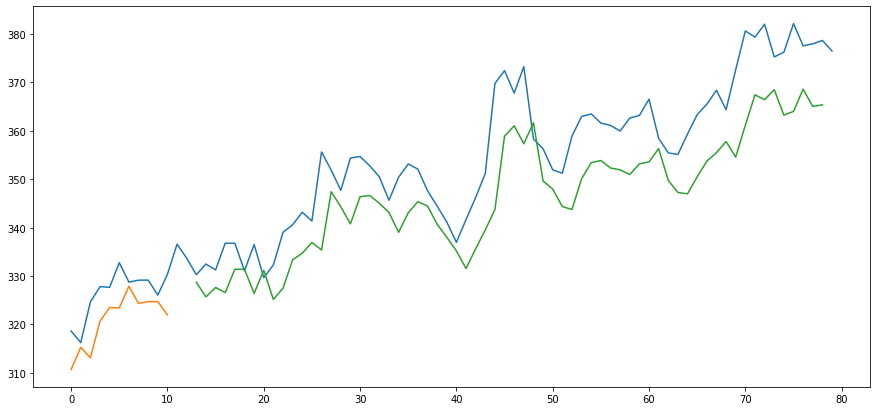

In [82]:

do_lstm_model_final(df = df_, 
              Y = 'Price', 
              look_back = 1,
              Epocas = 10)